In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model 
from tensorflow.keras.applications.inception_v3 import InceptionV3 
from tensorflow.keras.applications.inception_v3 import preprocess_input 
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img 
from tensorflow.keras import models 
from sklearn.model_selection import train_test_split
import tensorflow as tf 
import os
import tensorflow_datasets as tfds
import numpy as np
import glob 
import matplotlib.pyplot as plt 
from keras.models import load_model
import json
import joblib
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
im_size = 224
batch_size=25


In [ ]:
data_set = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/drive/MyDrive/AgriWise/ML/soli type/new_soil_types",
    shuffle = True, 
    image_size = (im_size, im_size),
    batch_size = batch_size
)

Found 2670 files belonging to 5 classes.


In [ ]:
categories = data_set.class_names
categories

['Black Soil', 'Cinder Soil', 'Laterite Soil', 'Peat Soil', 'Yellow Soil']

In [ ]:
len(data_set)

107

In [ ]:
for image_batch, label_batch in data_set.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(25, 224, 224, 3)
[4 4 2 4 3 3 0 0 2 0 0 2 2 0 4 0 4 0 0 0 0 0 0 3 4]


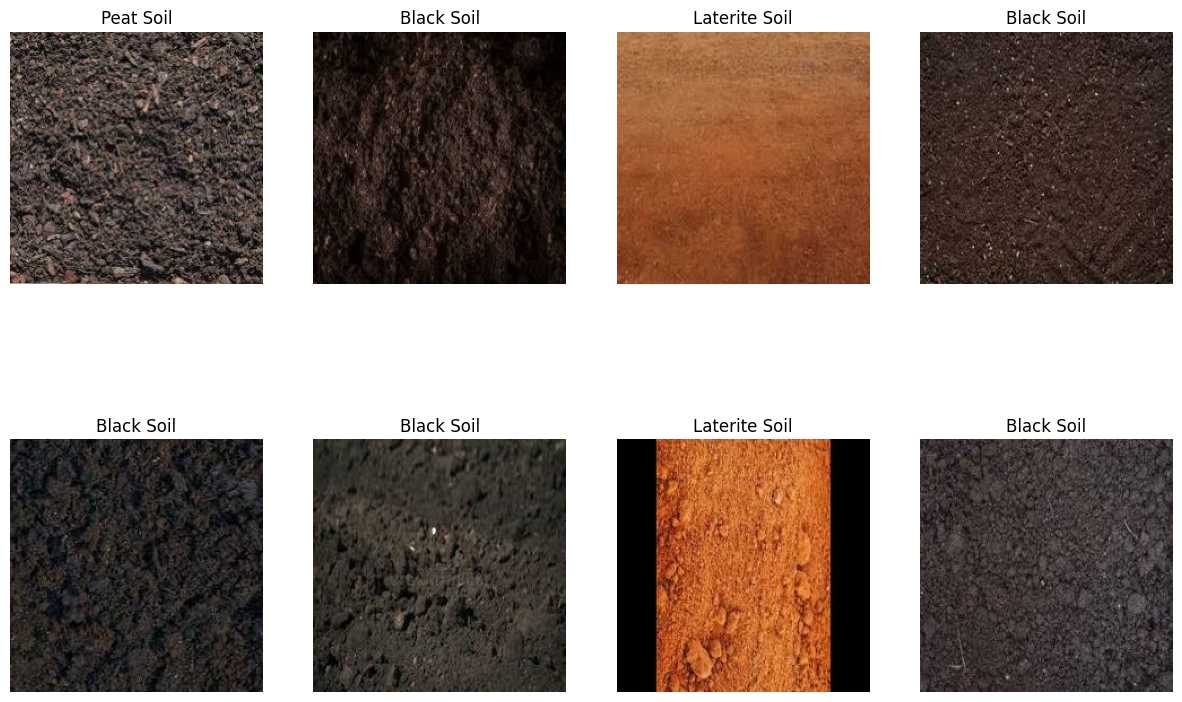

In [ ]:
plt.figure(figsize=(15, 15))
for image_batch, label_batch in data_set.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) 
        plt.title(categories[label_batch[i]])
        plt.axis("off")

In [ ]:

def train_valid_split(dataset, train_split = 0.8, valid_split=0.2, shuffle=True, shuffle_size=10000):
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    
    n_train = train_split * len(dataset)
    train_data = dataset.take(int(n_train))
    valid_data = dataset.skip(int(n_train))

    print("Train size: ",len(train_data))
    print("Valid size: ", len(valid_data))
    return train_data, valid_data

In [ ]:
train_data, valid_data = train_valid_split(data_set)


Train size:  85
Valid size:  22


In [ ]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_data = valid_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras import layers 
    
rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(im_size, im_size),
    layers.experimental.preprocessing.Rescaling(1.0/224)
    
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
input_shape=(batch_size,im_size,im_size,3)


In [ ]:
import tensorflow_hub as hub
mobile_net_model = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

In [ ]:
n_classes = len(categories)
model =models.Sequential([
    rescale,
    data_augmentation, 
    tf.keras.layers.InputLayer(input_shape=input_shape, dtype=tf.float32),
    hub.KerasLayer(mobile_net_model,trainable=False,dtype=tf.float32),
    Flatten(),
    Dense(5,activation='softmax')
])




In [ ]:
model.build(input_shape)

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (25, 224, 224, 3)         0         
                                                                 
 sequential_8 (Sequential)   (25, 224, 224, 3)         0         
                                                                 
 input_3 (InputLayer)        multiple                  0         
                                                                 
 keras_layer_2 (KerasLayer)  (25, 1280)                2257984   
                                                                 
 flatten_2 (Flatten)         (25, 1280)                0         
                                                                 
 dense_2 (Dense)             (25, 5)                   6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-tr

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
n_epochs = 20

history = model.fit(
    train_data,
    epochs = n_epochs, 
    batch_size = batch_size,
    verbose=1,
    validation_data=valid_data
)

Epoch 1/20
85/85 [==============================] - 126s 1s/step - loss: 0.7569 - accuracy: 0.7401 - val_loss: 0.4273 - val_accuracy: 0.8673
Epoch 2/20
85/85 [==============================] - 108s 1s/step - loss: 0.3304 - accuracy: 0.9090 - val_loss: 0.2906 - val_accuracy: 0.9145
Epoch 3/20
85/85 [==============================] - 108s 1s/step - loss: 0.2428 - accuracy: 0.9373 - val_loss: 0.2381 - val_accuracy: 0.9400
Epoch 4/20
85/85 [==============================] - 129s 2s/step - loss: 0.1795 - accuracy: 0.9566 - val_loss: 0.2033 - val_accuracy: 0.9509
Epoch 5/20
85/85 [==============================] - 111s 1s/step - loss: 0.1530 - accuracy: 0.9656 - val_loss: 0.1910 - val_accuracy: 0.9455
Epoch 6/20
85/85 [==============================] - 109s 1s/step - loss: 0.1376 - accuracy: 0.9660 - val_loss: 0.1633 - val_accuracy: 0.9600
Epoch 7/20
85/85 [==============================] - 107s 1s/step - loss: 0.1213 - accuracy: 0.9745 - val_loss: 0.1505 - val_accuracy: 0.9527
Epoch 8/20
85

In [ ]:
def draw_acc_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  #Train and validation accuracy
  plt.plot(epochs, acc, 'b', label='Training accurarcy')
  plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
  plt.title('Training and Validation accurarcy')
  plt.legend()
  plt.figure()
  #Train and validation loss
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and Validation loss')
  plt.legend()
  plt.show()


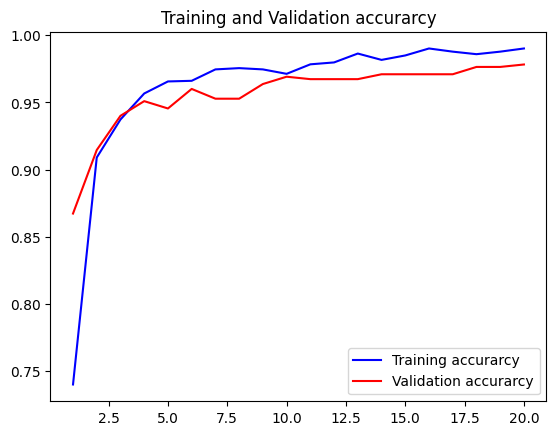

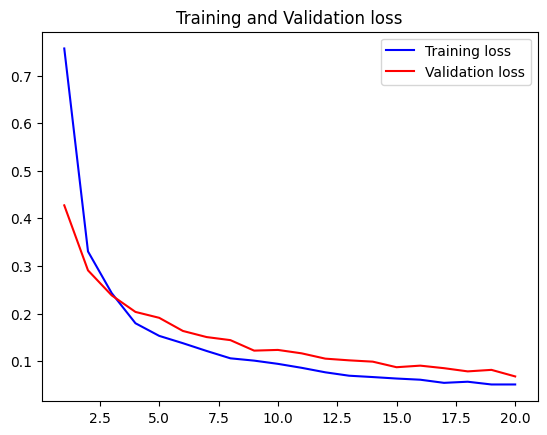

In [ ]:
draw_acc_loss(history)

In [ ]:
model.save("soilTypes1.h5")

In [ ]:
from tensorflow.keras.utils import CustomObjectScope
with CustomObjectScope({'KerasLayer': tf.keras.layers.Layer}):
    model =  tf.keras.models.load_model("soilTypes.h5", custom_objects={'KerasLayer':hub.KerasLayer})



In [ ]:
 def preprocessing(img_path):
        # Load image
        img = cv2.imread(img_path)

        #Resize image to 224x224
        img = cv2.resize(img, (224, 224))

        # Add batch dimension
        img = np.expand_dims(img, axis=0)

        return img


In [ ]:
def predict( input_data):
        return model.predict(input_data)

In [ ]:
 def postprocessing( prediction):
        categories = ['Black Soil', 'Cinder Soil', 'Laterite Soil', 'Peat Soil', 'Yellow Soil']
        index_max_predict = np.argmax(prediction)
        return categories[index_max_predict]

In [ ]:
 def compute_prediction( input_data):
        try:
            input_data = preprocessing(input_data)
            prediction = predict(input_data)[0]  # only one sample
            prediction = postprocessing(prediction)
        except Exception as e:
            return {"status": "Error", "message": str(e)}

      
        return prediction


In [ ]:
compute_prediction("/content/drive/MyDrive/AgriWise/ML/soli type/model2/Soil types/Yellow Soil/Yellow_Soil_ (1).jpg")

1/1 [==============================] - 0s 64ms/step


'Yellow Soil'

In [ ]:
compute_prediction("/content/drive/MyDrive/AgriWise/ML/soli type/model2/Soil types/Cinder Soil/Cinder_Soil_ (1).jpg")

1/1 [==============================] - 0s 144ms/step


'Cinder Soil'